In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import corner
import h5py
import lal
import pystan
import scipy.linalg as sl
import scipy.signal as sig
import scipy.stats as ss
import seaborn as sns
import qnm

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

INFO:root:Could not load Schw QNM dict from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/schwarzschild/data/Schw_dict.pickle


Here are the parameters that we used in [Isi, et al. (2019)](http://dx.doi.org/10.1103/PhysRevLett.123.111102).

In [3]:
ra = 1.95
dec = -1.27
psi = 0.82
cos_iota = -0.999

tgps_H = 1126259462.423

dt_H = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['H1'].location, ra, dec, lal.LIGOTimeGPS(tgps_H))
dt_L = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['L1'].location, ra, dec, lal.LIGOTimeGPS(tgps_H))

tgps_geocent = tgps_H - dt_H
tgps_L = tgps_geocent + dt_L

gmst = lal.GreenwichMeanSiderealTime(lal.LIGOTimeGPS(tgps_H))
FpH, FcH = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix['H1'].response, ra, dec, psi, gmst)
FpL, FcL = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix['L1'].response, ra, dec, psi, gmst)

In [4]:
FpH, FcH, FpL, FcL

(0.5787432123814908,
 -0.4509465159486486,
 -0.5274337839186076,
 0.20520844606870395)

In [5]:
with h5py.File('H-H1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Hstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Hts = linspace(T0, T0+32-1.0/4096, Hstrain.shape[0])

with h5py.File('L-L1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Lstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Lts = linspace(T0, T0+32-1/4096, Lstrain.shape[0])
    
fny = 1.0/(Hts[1]-Hts[0])/2.0

We will butterworth bandpass the data from 20 Hz to 1024 Hz (so a sample rate of 2048 Hz).  That allows us to decimate the data by a factor of two.  We also adjust the target peak time in H and L to match the nearest sample (at maximum sample rate---before decimation!), and, finally, we ensure that this sample will remain after decimation (so we roll the data by one if it is an odd index---`decimate` returns even indices if the decimation step is 2).

In [6]:
# Find the nearest sample in H to the designated end time.
iH = np.argmin(np.abs(Hts - tgps_H))
dt_LH = tgps_L - tgps_H
tgps_H = Hts[iH]

# Now translate the end time in L to correspond to an exact H sample.
tgps_L = tgps_H + dt_LH
# iL = np.argmin(np.abs(Lts - tgps_L)) + 1 ###### DANGER!  Added 1 here to match Max
iL = np.argmin(np.abs(Lts - tgps_L))
tgps_L = Lts[iL]

# if Hts[iH] > tgps_H:
#     iH -= 1
# if Lts[iL] > tgps_L:
#     iL -= 1

if iH % 2 == 1:
    print('Rolling H by one sample')
    Hstrain = roll(Hstrain, -1)
    Hts = roll(Hts, -1)
if iL % 2 == 1:
    print('Rolling L by one sample')
    Lstrain = roll(Lstrain, -1)
    Lts = roll(Lts, -1)

fLow = 20.0 # Hz
ds_factor = 2
b, a = sig.butter(4, fLow/fny, btype='highpass', output='ba')
Hfilt = sig.filtfilt(b, a, Hstrain)
Lfilt = sig.filtfilt(b, a, Lstrain)

Hfilt = sig.decimate(Hfilt, ds_factor, zero_phase=True)
Lfilt = sig.decimate(Lfilt, ds_factor, zero_phase=True)

Hfilt = Hfilt - mean(Hfilt)
Lfilt = Lfilt - mean(Lfilt)

Htsfilt = Hts[::ds_factor]
Ltsfilt = Lts[::ds_factor]

# Grab the first sample before merger
I0H = np.argmin(np.abs(Htsfilt - tgps_H))
I0L = np.argmin(np.abs(Ltsfilt - tgps_L))

print('tgps_H = {:.6f}'.format(tgps_H))
print('tgps_L = {:.6f}'.format(tgps_L))

print('t0_H - tgps_H is {:.5f} s'.format(Htsfilt[I0H]-tgps_H))
print('t0_L - tgps_L is {:.5f} s'.format(Ltsfilt[I0L]-tgps_L))

gamma_min = 100.0
min_decay = 5.0
Nanalyze = int(round(min_decay / (gamma_min*(Htsfilt[1]-Htsfilt[0]))))
Tanalyze = Nanalyze*(Htsfilt[1]-Htsfilt[0])
print('Will analyze {:.3f} s of data'.format(Tanalyze))

Rolling H by one sample
tgps_H = 1126259462.423096
tgps_L = 1126259462.416016
t0_H - tgps_H is 0.00000 s
t0_L - tgps_L is 0.00000 s
Will analyze 0.050 s of data


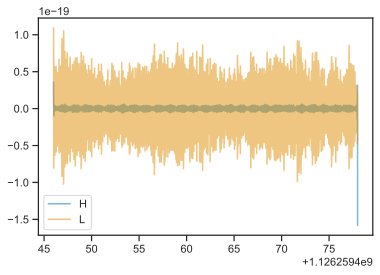

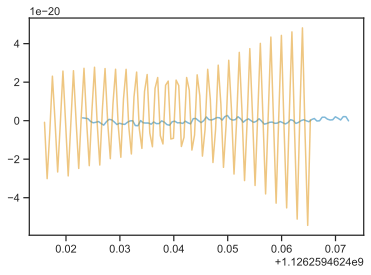

In [7]:
plot(Htsfilt, Hfilt, label='H', alpha=0.5)
plot(Ltsfilt, Lfilt, label='L', alpha=0.5)

legend(loc='best')

figure()
plot(Htsfilt[I0H:I0H+Nanalyze], Hfilt[I0H:I0H+Nanalyze], label='H', alpha=0.5)
plot(Ltsfilt[I0L:I0L+Nanalyze], Lfilt[I0L:I0L+Nanalyze], label='L', alpha=0.5)

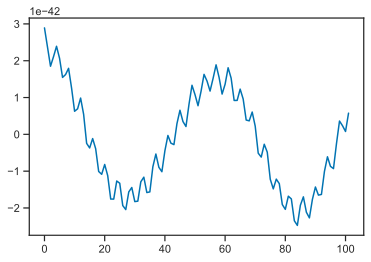

In [8]:
# We want to be sure the filter has warmed up, so discard the first and last 1/4 of the data.
Ttrim = 8 # Seconds
Ntrim = Ttrim*2048

Hrho = sig.correlate(Hfilt[Ntrim:-Ntrim], Hfilt[Ntrim:-Ntrim])
Hrho = ifftshift(Hrho)
Hrho = Hrho / len(Hfilt[Ntrim:-Ntrim])
plot(Hrho[:Nanalyze])

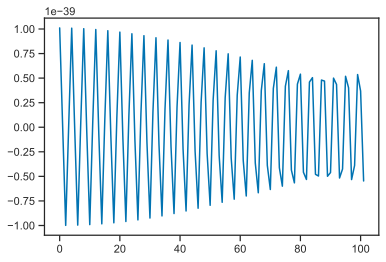

In [9]:
Lrho = sig.correlate(Lfilt[Ntrim:-Ntrim], Lfilt[Ntrim:-Ntrim])
Lrho = ifftshift(Lrho)
Lrho = Lrho / len(Lfilt[Ntrim:-Ntrim])
plot(Lrho[:Nanalyze])

In [10]:
HC = sl.toeplitz(Hrho[:Nanalyze])
HCorr = sl.toeplitz(HC[0,:]/HC[0,0])
HL = np.linalg.cholesky(HC)
HCorrL = np.linalg.cholesky(HCorr)

LC = sl.toeplitz(Lrho[:Nanalyze])
LCorr = sl.toeplitz(LC[0,:]/LC[0,0])
LL = np.linalg.cholesky(LC)
LCorrL = np.linalg.cholesky(LCorr)

This is something like the GW150914 plot: whitened data, with L shifted and inverted.

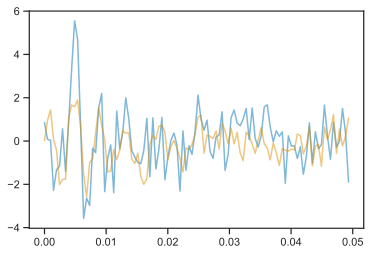

In [11]:
t = (Htsfilt[1]-Htsfilt[0])*arange(Nanalyze)
plot(t, np.linalg.solve(HL, Hfilt[I0H:I0H+Nanalyze]), label='H', alpha=0.5)
plot(t, -np.linalg.solve(LL, Lfilt[I0L:I0L+Nanalyze]), label='L', alpha=0.5)

In [12]:
mref = 68.0
fref = 2.98e3 # Hz, at 68 MSun
chi0 = 0.69

g220 = qnm.modes_cache(-2, 2, 2, 0)
omega, _, _ = g220(a=chi0)
f0 = real(omega)/(2*pi) * fref
gamma0 = abs(imag(omega)) * fref

g221 = qnm.modes_cache(-2, 2, 2, 1)
omega, _, _ = g221(a=chi0)
f1 = real(omega)/(2*pi) * fref
gamma1 = abs(imag(omega)) * fref

g222 = qnm.modes_cache(-2, 2, 2, 1)
omega, _, _ = g222(a=chi0)
f2 = real(omega)/(2*pi) * fref
gamma2 = abs(imag(omega)) * fref

print('Given estimated tau0, expect signal to be down by exp(-{:.1f}) by end of data'.format(gamma0*Tanalyze))

INFO:root:Loading Kerr QNM sequence from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/data/s-2_l2_m2_n0.pickle
INFO:root:Loading Kerr QNM sequence from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/data/s-2_l2_m2_n0.pickle
INFO:root:Loading Kerr QNM sequence from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/data/s-2_l2_m2_n1.pickle
INFO:root:Loading Kerr QNM sequence from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/data/s-2_l2_m2_n1.pickle


Given estimated tau0, expect signal to be down by exp(-12.0) by end of data


In [13]:
model_constrained = pystan.StanModel(file='ringdown_constrained.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4ea8f7971cf758142f1249c2a32c75e2 NOW.
/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpzvda10t4/stanfit4anon_model_4ea8f7971cf758142f1249c2a32c75e2_4372485516961208761.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [14]:
data_constrained = {
    'nobs': 2,
    'nsamp': Nanalyze,
    
    't0': [tgps_H, tgps_L],
    'ts': [Htsfilt[I0H:I0H+Nanalyze], Ltsfilt[I0L:I0L+Nanalyze]],
    'strain': [Hfilt[I0H:I0H+Nanalyze], Lfilt[I0L:I0L+Nanalyze]],
    'L': [HL, LL],

    'MMin': 50.0,
    'MMax': 100.0,
    
    'FpFc': [[FpH, FcH], [FpL, FcL]],
    'cos_inc': cos_iota,
    
    'Amax': 1e-19,
    
    'df_max': 1e-3, # No deviation from GR.
    'dtau_max': 1e-3
}

In [15]:
n = 1
fit_constrained = model_constrained.sampling(data=data_constrained, iter=2000*n, thin=n)
fit_constrained = az.convert_to_inference_data(fit_constrained)

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [16]:
data_modgr = data_constrained.copy()
data_modgr['df_max'] = 0.5
data_modgr['dtau_max'] = 0.9

In [17]:
n = 1
fit_modgr = model_constrained.sampling(data=data_modgr, iter=2000*n, thin=n)
fit_modgr = az.convert_to_inference_data(fit_modgr)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11efe4ac8>,
      dtype=object)

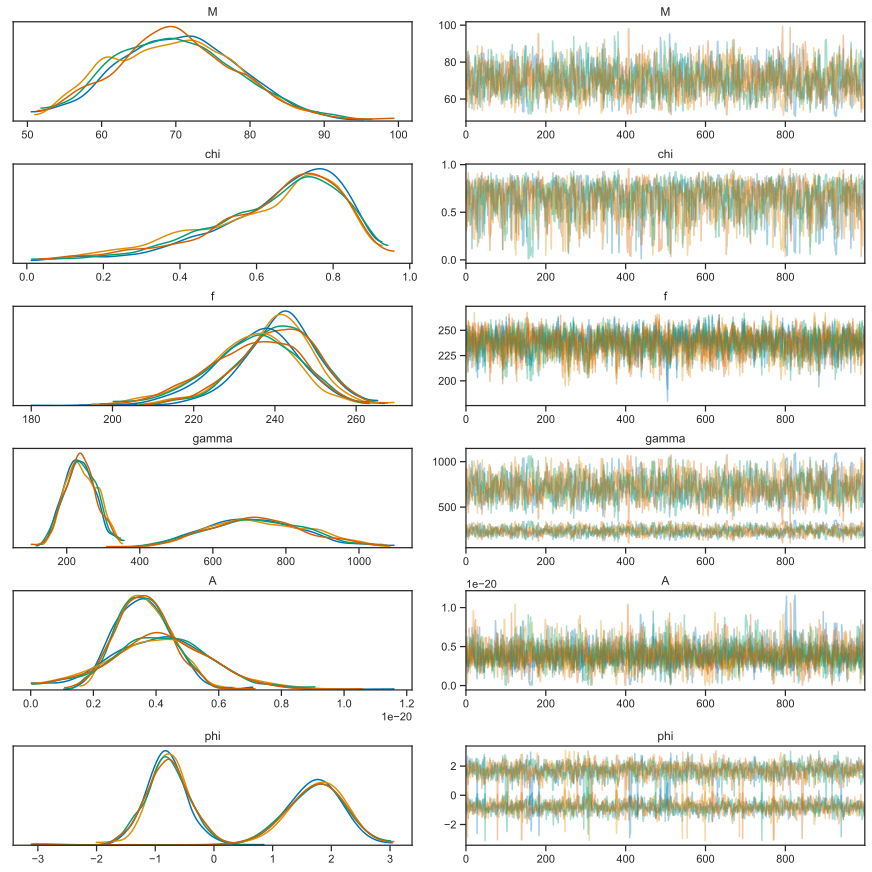

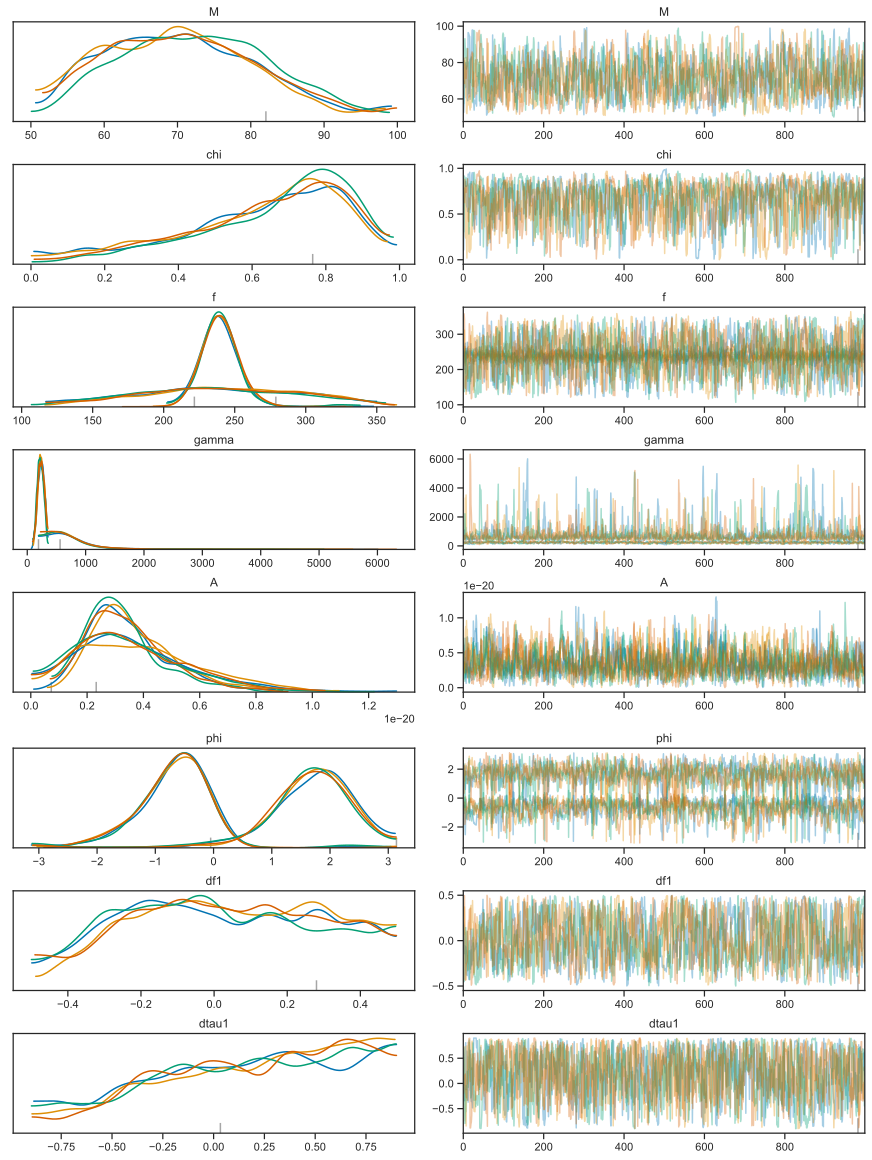

In [19]:
az.plot_trace(fit_constrained,
              var_names=['M', 'chi', 'f', 'gamma', 'A', 'phi'], compact=True)
az.plot_trace(fit_modgr,
              var_names=['M', 'chi', 'f', 'gamma', 'A', 'phi', 'df1', 'dtau1'], compact=True)

Execute this to save the fit:

In [20]:
az.to_netcdf(fit_constrained, 'GW150914_GR.nc')
az.to_netcdf(fit_modgr, 'GW150914.nc')

'GW150914.nc'

Execute this to load the fit from disk:

In [20]:
fit_constrained = az.from_netcdf('GW150914_GR.nc')
fit_modgr = az.from_netcdf('GW150914.nc')

A1 = 4.2e-21 +/- 1.7e-21
A1 > 0 at 2.5 sigma


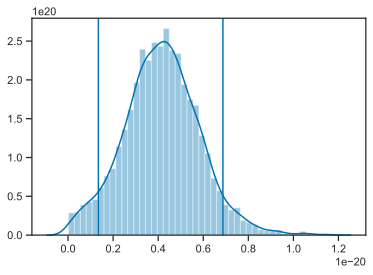

In [21]:
A1 = fit_constrained.posterior.A.values[:,:,1].flatten()

sns.distplot(A1)

print('A1 = {:.2g} +/- {:.2g}'.format(mean(A1), std(A1)))
print('A1 > 0 at {:.2g} sigma'.format(mean(A1)/std(A1)))

axvline(percentile(A1, 5), color=sns.color_palette()[0])
axvline(percentile(A1, 95), color=sns.color_palette()[0])

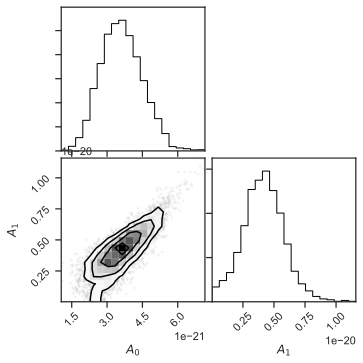

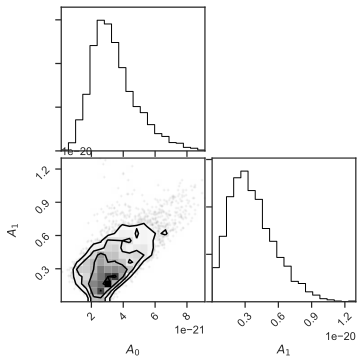

In [22]:
corner.corner(fit_constrained.posterior.A.values.reshape((-1, 2)),
              labels=[r'$A_0$', r'$A_1$']);
corner.corner(fit_modgr.posterior.A.values.reshape((-1, 2)),
              labels=[r'$A_0$', r'$A_1$']);

This should be like the plot in the paper showing our $M_f$, $\chi_f$ constraints.

In [23]:
paper_fit1 = genfromtxt('paperfits/isi_n1_t0.dat.gz', usecols=(0,1))

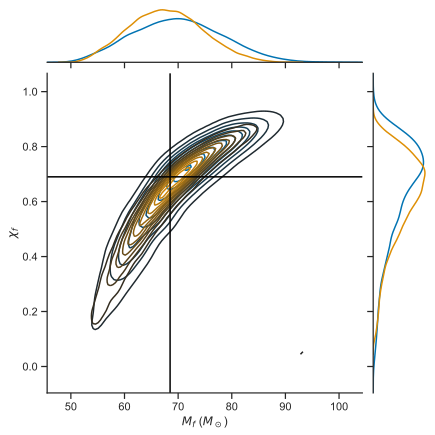

In [24]:
g = sns.JointGrid(fit_constrained.posterior.M.values.flatten(), fit_constrained.posterior.chi.values.flatten())
g.plot(sns.kdeplot, sns.kdeplot)

g.x = paper_fit1[:,0]
g.y = paper_fit1[:,1]
g.plot(sns.kdeplot, sns.kdeplot)

g.ax_joint.axvline(68.5, color='k')
g.ax_joint.axhline(0.69, color='k')

g.set_axis_labels(xlabel=r'$M_f$ ($M_\odot$)', ylabel=r'$\chi_f$')

This is similar to the plot in the paper:

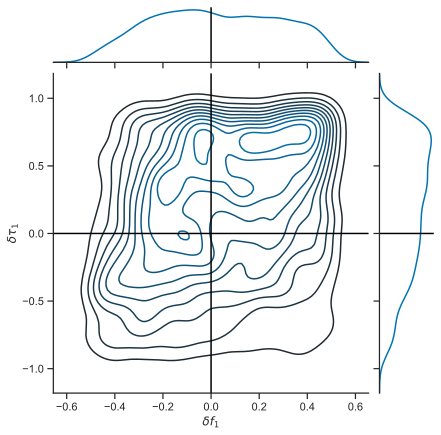

In [25]:
g = sns.JointGrid(fit_modgr.posterior.df1.values.flatten(), fit_modgr.posterior.dtau1.values.flatten())

g.plot(sns.kdeplot, sns.kdeplot)

g.ax_joint.axhline(0, color='k')
g.ax_joint.axvline(0, color='k')

g.ax_marg_y.axhline(0, color='k')
g.ax_marg_x.axvline(0, color='k')

g.set_axis_labels(xlabel=r'$\delta f_1$', ylabel=r'$\delta \tau_1$')

delta_f1 = 0.02 + 0.31 - 0.27


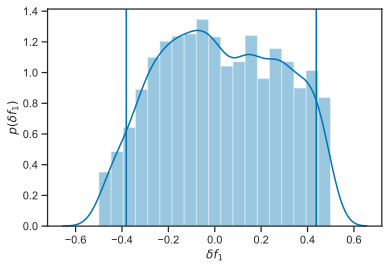

In [28]:
sns.distplot(fit_modgr.posterior.df1.values.flatten())
axvline(percentile(fit_modgr.posterior.df1, 5), color=sns.color_palette()[0])
axvline(percentile(fit_modgr.posterior.df1, 95), color=sns.color_palette()[0])

xlabel(r'$\delta f_1$')
ylabel(r'$p\left( \delta f_1 \right)$')

m = median(fit_modgr.posterior.df1)
h = percentile(fit_modgr.posterior.df1, 84)
l = percentile(fit_modgr.posterior.df1, 16)

print('delta_f1 = {:.2f} + {:.2f} - {:.2f}'.format(m, h-m, m-l))

Our Bayes factor doesn't work out to quite the same thing, but pretty close: a weak preference in favour of GR as a model.  We compute it by first logit-transforming the $\delta f_1$ and $\delta \tau_1$ parameters into an un-bounded space, then using a KDE to estimate their density at $\delta f_1 = \delta \tau_1 = 0$.  This density divided by the prior is the Savage-Dickie ratio, which gives the Bayes factor in favour of the embedded GR model at this point.

In [29]:
def logit_transform(x, low, high):
    return log(x-low)-log(high-x)

def logit_jacobian(x, low, high):
    return 1.0/(x-low) + 1.0/(high-x)
    
pts = row_stack((logit_transform(fit_modgr.posterior.df1.values.flatten(), -0.5, 0.5), logit_transform(fit_modgr.posterior.dtau1.values.flatten(), -0.9, 0.9)))
    
kde = ss.gaussian_kde(pts)

print('GR bayes factor = {:.2f}'.format(float(kde([0.0, 0.0])) / (1.0/1.8/logit_jacobian(0, -0.5, 0.5)/logit_jacobian(0, -0.9, 0.9))))

GR bayes factor = 1.21


Here is the signal in the two detectors:

Text(0, 0.5, '$h(t)$')

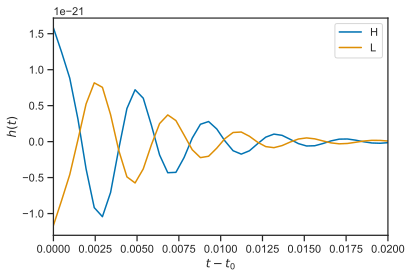

In [30]:
plot(Htsfilt[I0H:I0H+Nanalyze]-tgps_H, mean(fit_constrained.posterior.h_det.values[:,:,0,:], axis=(0,1)), label='H')
plot(Ltsfilt[I0L:I0L+Nanalyze]-tgps_L, mean(fit_constrained.posterior.h_det.values[:,:,1,:], axis=(0,1)), label='L')
legend(loc='best')
axis(xmin=0, xmax=0.02)
xlabel(r'$t-t_0$')
ylabel(r'$h(t)$')

Whitened:

(1126259462.4160156,
 1126259462.4404297,
 -3.2218714327594173,
 3.8916365840359823)

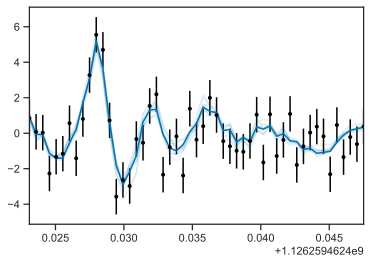

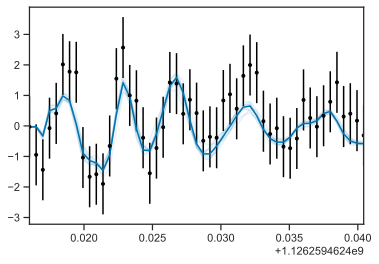

In [31]:
Nplot = 50
errorbar(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, Hfilt[I0H:I0H+Nanalyze]), yerr=ones(Nanalyze), fmt='.', color='k')
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, mean(fit_constrained.posterior.h_det.values[:,:,0,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit_constrained.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, fit_constrained.posterior.h_det.values[k,l,0,:]), color=sns.color_palette()[0], alpha=0.1)
axis(xmin=Htsfilt[I0H], xmax=Htsfilt[I0H+Nplot])    
    
figure()

errorbar(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, Lfilt[I0L:I0L+Nanalyze]), yerr=ones(Nanalyze), fmt='.', color='k')
plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, mean(fit_constrained.posterior.h_det.values[:,:,1,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit_constrained.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, fit_constrained.posterior.h_det.values[k,l,1,:]), color=sns.color_palette()[0], alpha=0.1)
axis(xmin=Ltsfilt[I0L], xmax=Ltsfilt[I0L+Nplot])

Whitened residuals and their ACF; vertical line in the ACF indicates a reasonable guess at fundamental frequency.

(0, 0.0244140625, -0.2150791253495116, 1.0578609107309291)

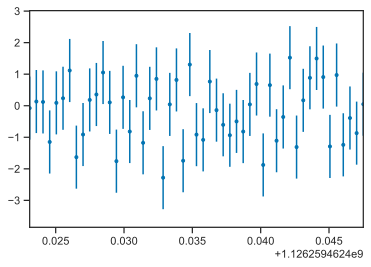

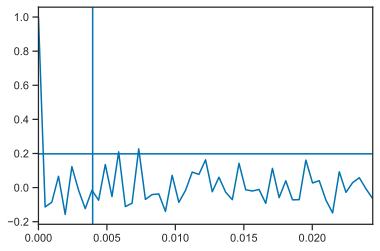

In [32]:
rH = Hfilt[I0H:I0H+Nanalyze] - fit_constrained.posterior.h_det.values[:,:,0,:]
wrH = np.linalg.solve(HL, mean(rH, axis=(0,1)))

errorbar(Htsfilt[I0H:I0H+Nanalyze], wrH, yerr=ones(Nanalyze), fmt='.')
axis(xmin=Htsfilt[I0H], xmax=Htsfilt[I0H+Nplot])    

figure()

acf = sig.correlate(wrH, wrH)
acf = ifftshift(acf)
acf /= acf[0]
acf = acf[:len(wrH)]

plot((Htsfilt[1]-Htsfilt[0])*arange(len(acf)), acf)
axhline(2/sqrt(len(acf)))
axvline(1/(fref*real(g220(0.7)[0]/(2*pi))))
axis(xmin=0, xmax=Nplot*(Htsfilt[1]-Htsfilt[0]))

(0, 0.0244140625, -0.19348897611797206, 1.0568328083865701)

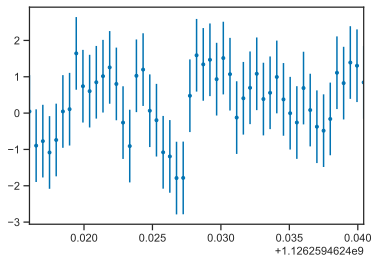

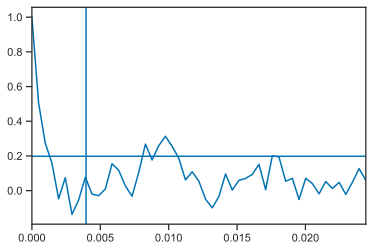

In [33]:
rL = Lfilt[I0L:I0L+Nanalyze] - 2*fit_constrained.posterior.h_det.values[:,:,1,:]
wrL = np.linalg.solve(LL, mean(rL, axis=(0,1)))

errorbar(Ltsfilt[I0L:I0L+Nanalyze], wrL, yerr=ones(Nanalyze), fmt='.')
axis(xmin=Ltsfilt[I0L], xmax=Ltsfilt[I0L+Nplot])
figure()

acf = sig.correlate(wrL, wrL)
acf = ifftshift(acf)
acf /= acf[0]
acf = acf[:len(wrL)]

plot((Ltsfilt[1]-Ltsfilt[0])*arange(len(acf)), acf)
axhline(2/sqrt(len(acf)))
axvline(1/(fref*real(g220(0.7)[0]/(2*pi))))
axis(xmin=0, xmax=Nplot*(Ltsfilt[1]-Ltsfilt[0]))

## Computing Fitting Formulae for Kerr Ringdown Modes

It is a bit un-satisfying to have to find the modes independently; let's instead compute some fitting formluae for the behaviour of the freq and damping rate so we can encode this in Stan.

In [69]:
chis = linspace(0, 1, 1000)[:-1]

In [70]:
freqs0 = array([fref*real(g220(c)[0])/(2*pi) for c in chis])
freqs1 = array([fref*real(g221(c)[0])/(2*pi) for c in chis])

gams0 = array([fref*abs(imag(g220(c)[0])) for c in chis])
gams1 = array([fref*abs(imag(g221(c)[0])) for c in chis])

In [79]:
M = column_stack((ones_like(chis), log(1-chis), chis, chis*chis, chis*chis*chis, chis*chis*chis*chis))

In [80]:
coeff_f0 = np.linalg.lstsq(M, freqs0/fref)[0]

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


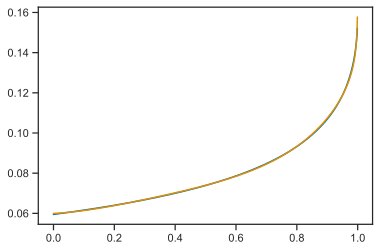

In [82]:
plot(chis, freqs0/fref)
plot(chis, np.dot(M, coeff_f0))

In [84]:
coeff_f1 = np.linalg.lstsq(M, freqs1/fref)[0]

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


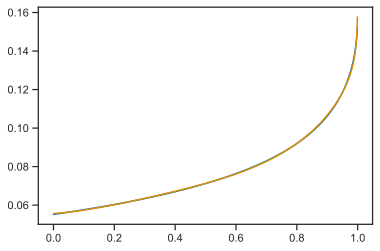

In [85]:
plot(chis, freqs1/fref)
plot(chis, np.dot(M, coeff_f1))

In [88]:
coeff_g0 = np.linalg.lstsq(M, gams0/fref)[0]

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


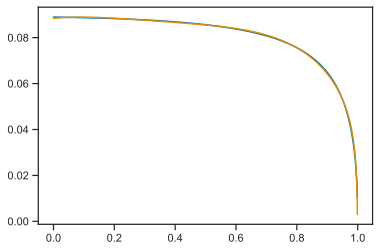

In [89]:
plot(chis, gams0/fref)
plot(chis, np.dot(M, coeff_g0))

In [92]:
coeff_g1 = np.linalg.lstsq(M, gams1/fref)[0]

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


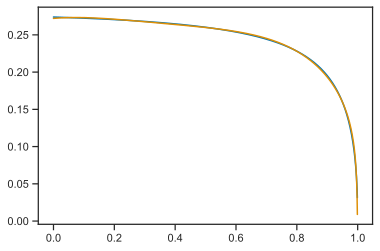

In [93]:
plot(chis, gams1/fref)
plot(chis, np.dot(M, coeff_g1))

In [94]:
coeff_f0, coeff_f1, coeff_g0, coeff_g1

(array([ 0.05994978, -0.00823557, -0.00106621,  0.08354181, -0.15165638,
         0.11021346]),
 array([ 0.05566214, -0.00817462,  0.00174686,  0.08531498, -0.15464552,
         0.11325923]),
 array([ 0.08838127,  0.01180702,  0.02528302, -0.09002286,  0.18245511,
        -0.12162592]),
 array([ 0.27212686,  0.03544845,  0.0702625 , -0.27797961,  0.55851284,
        -0.36945098]))

## Comparisons With [Carullo, Del Pozzo, & Veitch (2019)](http://dx.doi.org/10.1103/PhysRevD.99.123029)

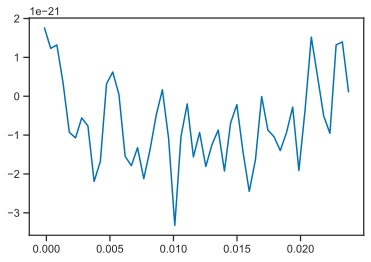

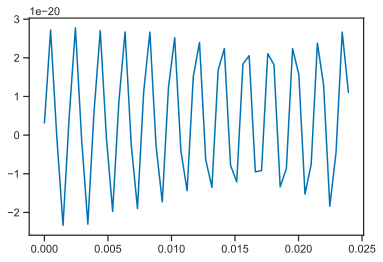

In [52]:
N = 50
plot(Htsfilt[I0H:I0H+N] - tgps_H, Hfilt[I0H:I0H+N])

figure()
plot(Ltsfilt[I0L:I0L+N] - tgps_L, Lfilt[I0H:I0H+N])